# Born to slide: mobile origin licensing factors confer resistance to transcription conflicts

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ 5B
+ 5C
+ 5D
+ S5C
+ S5D
+ S5E
+ S5F

#### Archives:
+ Transcription_licensed-DNA_ATPgS_LS.yama
+ Transcription_licensed-DNA_ATPgS_HS.yama
+ Transcription_licensed-DNA_T7T_ATPgS.yama
+ Transcription_naked-DNA_ATPgS_LD555.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from scipy.stats import norm
from tqdm.notebook import tqdm
from functools import reduce
from collections import Counter

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Transcription_licensed-DNA_ATPgS_LS.yama',
                     'Transcription_licensed-DNA_ATPgS_HS.yama',
                     'Transcription_licensed-DNA_T7T_ATPgS.yama',
                     'Transcription_naked-DNA_ATPgS_LD555.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure5/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure5/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

cdc6 not found. Setting default to n/a



### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
Transcription_licensed-DNA_ATPgS_LS,1,283,ybbR-LD555-T7; ybbR-LD655-MCM,ATPgS,False,n/a,False,passed
Transcription_licensed-DNA_ATPgS_HS,1,63,ybbR-LD555-T7; ybbR-LD655-MCM,ATPgS,True,n/a,False,passed
Transcription_licensed-DNA_T7T_ATPgS,2,482,SNAP-AF488-T7; SORT-LD555-ORC; ybbR-LD655-MCM,ATPgS,False,n/a,True,passed
Transcription_naked-DNA_ATPgS_LD555,3,224,ybbR-LD555-T7,ATPgS,False,n/a,False,passed


### Load segment tables, apply filter & detect pauses

In [9]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    archive.filter_segments(b_min=-10, sigma_b_max=10)
    archive.detect_pauses()


### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''
    Sets up a multilevel df with all relevant information
    '''
    
    # indices will be UIDs
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['initial_intensity', 'lifetime', 'start_site', 'stop_site', 'number_pauses']
    col_3 = ['']
    hier_index = pd.MultiIndex.from_product([col_1,col_2,col_3],names=['molecule','properties','properties_details'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(MCM_1_, initial_intensity, ), (MCM_1_, lifetime, ), (MCM_1_, number_pauses, ), (MCM_1_, start_site, ), (MCM_1_, stop_site, ), (MCM_2_, initial_intensity, ), (MCM_2_, lifetime, ), (MCM_2_, number_pauses, ), (MCM_2_, start_site, ), (MCM_2_, stop_site, ), (ORC_1_, initial_intensity, ), (ORC_1_, lifetime, ), (ORC_1_, number_pauses, ), (ORC_1_, start_site, ), (ORC_1_, stop_site, ), (ORC_2_, initial_intensity, ), (ORC_2_, lifetime, ), (ORC_2_, number_pauses, ), (ORC_2_, start_site, ), (ORC_2_, stop_site, ), (T7_1_, initial_intensity, ), (T7_1_, lifetime, ), (T7_1_, number_pauses, ), (T7_1_, start_site, ), (T7_1_, stop_site, )]
Index: []

[0 rows x 25 columns]

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        #print('handling molecule '+molecule.uid)
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'dna_count_valid'] = archive.dna_count_valid
        df.loc[molecule.uid,'hs_wash'] = archive.highsalt_wash
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'t7_terminator'] = archive.t7_terminator
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)

        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
            
            # burst velocity (weighted average, exclude pauses, all regions)
            # always calculate weighted average for all seg_dfs of a protein
            # check if protein has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))) > 0:
                df.loc[molecule.uid,('velocity_'+protein)] = \
                np.average([seg_df.calc_rate()[0] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))],
                           weights=[seg_df.calc_rate()[1] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))])
        
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 5 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:5][prefix+'Intensity'].mean()

            #lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())
            
            #start & stop site
            if re.match('T7',prefix):
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df[prefix+'Position_on_DNA'].min()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            elif re.match('MCM',prefix):
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df.iloc[:5][prefix+'Position_on_DNA'].mean()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            
            #pauses:
            #number of pauses
            #- do not consider first segment (transcription stalling before UTP arrival)
            #- do not consider pauses above 19 kb on DNA (exclude diffraction limit towards end of DNA = 1.5-2kb)
            #- do not consider pauses with less than 20 seconds (x2-x1)
            
            #note: following is split up in multiple lines to avoid long arguments and reusage
            #save as temporal variable (already exclude exclude first segment of each segment table (index 0 stays in concatenated))
            # check if protein prefix has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))) > 0:
                _seg_df = pd.concat([seg_df.df for seg_df in list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))]).drop(0,axis=0)
                # reset index for proper loops by index later
                _seg_df.reset_index(drop=True, inplace=True)
                # filter df based on pause definition (keep all segments which are not a pause for recovery)
                _seg_df = _seg_df[(_seg_df['x2'] - _seg_df['x1'] >= 20) & 
                                  (_seg_df['y2'] < 19000) & (_seg_df['y1'] < 19000) | 
                                  (_seg_df['pause_B'] == False)]
                             
            
                df.loc[molecule.uid,(prefix,'number_pauses')] = _seg_df['pause_B'].sum()
            
                #loop through filtered _seg_df to get pause details:
                pause_counter = 0
                for row in _seg_df.index:
                    #do we have a pause segment?
                    if _seg_df.loc[row,'pause_B']:
                        pause_counter+=1

                        # pause duration (endtime - starttime: x2-x1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'duration')] = \
                        _seg_df.loc[row,'x2'] - _seg_df.loc[row,'x1']

                        # pause position on dna (mean of start and end: y2-y1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'position_on_dna')] = \
                        (_seg_df.loc[row,'y2'] + _seg_df.loc[row,'y1']) / 2

                        # does it recover from pause (=> is it the last segment)
                        # note: concatenated df is perfect because subsequent region can show pause recovery
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'recovery')] = \
                        row != _seg_df.index.max()

                # sanity check between pause_counter and earlier detected pauses
                # [0] necessary because of multi-index. use .xs() alternatively
                if pause_counter != df.loc[molecule.uid,(prefix,'number_pauses')][0]:
                    print(f"Attention! Problem with pause detection in molecule {molecule.uid}.")           

# fill all NaN values in number_protein with 0
proteins = set()
for archive in DnaMoleculeArchive.instances:
    proteins.update(archive.proteins)

for protein in proteins:
    df['number_'+protein] = df['number_'+protein].apply(lambda value: 0 if np.isnan(value) else value)
                    
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [13]:
df.head()

molecule                          MCM_1_                                  \
properties             initial_intensity lifetime number_pauses  pause_1   
properties_details                                              duration   
ieQwV6aDnrXypabArn9wxK           30135.4    200.0           0.0      NaN   
6WWUeuYF81fiqUQ1eBop1m               NaN      NaN           NaN      NaN   
ntzohE8juHpTgESMDENF9T           14723.7    138.0           0.0      NaN   
tPDHFmGT4FCZfu4oWkxLYQ           14026.4    145.0           0.0      NaN   
njwaKPQkSS9K6UFxLBKNGC               NaN      NaN           NaN      NaN   

molecule                                                                  \
properties                                       pause_2                   
properties_details     position_on_dna recovery duration position_on_dna   
ieQwV6aDnrXypabArn9wxK             NaN      NaN      NaN             NaN   
6WWUeuYF81fiqUQ1eBop1m             NaN      NaN      NaN             NaN   
ntzohE8juHpTgESMDENF9T             NaN      NaN      NaN             NaN   
tPDHFmGT4FCZfu4oWkxLYQ             NaN      NaN      NaN             NaN   
njwaKPQkSS9K6UFxLBKNGC             NaN      NaN      NaN             NaN   

molecule                                      ...    label_T7 nucleotide  \
properties                        start_site  ...                          
properties_details     recovery               ...                          
ieQwV6aDnrXypabArn9wxK      NaN  6262.440662  ...  ybbR-LD555      ATPgS   
6WWUeuYF81fiqUQ1eBop1m      NaN          NaN  ...  ybbR-LD555      ATPgS   
ntzohE8juHpTgESMDENF9T      NaN  4418.542934  ...  ybbR-LD555      ATPgS   
tPDHFmGT4FCZfu4oWkxLYQ      NaN  4954.030712  ...  ybbR-LD555      ATPgS   
njwaKPQkSS9K6UFxLBKNGC      NaN          NaN  ...  ybbR-LD555      ATPgS   

molecule               number_MCM number_ORC number_T7 t7_terminator  \
properties                                                             
properties_details                                                     
ieQwV6aDnrXypabArn9wxK        1.0        0.0       1.0         False   
6WWUeuYF81fiqUQ1eBop1m        0.0        0.0       1.0         False   
ntzohE8juHpTgESMDENF9T        1.0        0.0       1.0         False   
tPDHFmGT4FCZfu4oWkxLYQ        2.0        0.0       1.0         False   
njwaKPQkSS9K6UFxLBKNGC        0.0        0.0       1.0         False   

molecule                                           tags velocity_MCM  \
properties                                                             
properties_details                                                     
ieQwV6aDnrXypabArn9wxK   [accept, coll_T7_1_MCM_1_push]    28.510461   
6WWUeuYF81fiqUQ1eBop1m                         [accept]          NaN   
ntzohE8juHpTgESMDENF9T  [accept, coloc_T7_1_MCM_1_push]    25.151466   
tPDHFmGT4FCZfu4oWkxLYQ  [accept, coloc_T7_1_MCM_1_push]    26.594233   
njwaKPQkSS9K6UFxLBKNGC                         [accept]          NaN   

molecule               velocity_ORC velocity_T7  
properties                                       
properties_details                               
ieQwV6aDnrXypabArn9wxK          NaN   28.827112  
6WWUeuYF81fiqUQ1eBop1m          NaN   29.406737  
ntzohE8juHpTgESMDENF9T          NaN   23.615243  
tPDHFmGT4FCZfu4oWkxLYQ          NaN   26.013924  
njwaKPQkSS9K6UFxLBKNGC          NaN   29.353389  

[5 rows x 58 columns]

## Figures

 ### Figure 5B: Collision outcomes RNAP-OCCM
*Note*: only consider collisions in absence of ORC and archives with valid DNA count

In [14]:
# 2-color data
colls = list()

for archive in filter(lambda archive: archive.dna_count_valid, DnaMoleculeArchive.instances):
    for molecule in archive.molecules:
        for tag in filter(lambda tag: 'coll_T7_1_MCM_' in tag, molecule.tags):
            colls.append(tag.split('_')[-1])

df_coll = pd.DataFrame(index=['outcome'],data=([Counter(colls)])).T

df_coll

,outcome
push,80
T7eject,28
stall,4
MCMeject,7
pause,2


In [15]:
df_coll = df_coll.reindex(['push', 'pause', 'stall', 'T7eject','MCMeject'])
df_coll

,outcome
push,80
pause,2
stall,4
T7eject,28
MCMeject,7


In [16]:
# add 3-color data
colls = list()

for archive in filter(lambda archive: archive.dna_count_valid, DnaMoleculeArchive.instances):
    for molecule in archive.molecules:
        for tag in filter(lambda tag: 'coll_T7_1_ORC_1_MCM_' in tag, molecule.tags):
            # rename 'ORCpush-MCMeject' to MCMeject:
            if tag.split('_')[-1] == 'ORCpush-MCMeject':
                colls.append('MCMeject')
            else:
                colls.append(tag.split('_')[-1])

df_coll3c = pd.DataFrame(index=['outcome'],data=([Counter(colls)])).T


df_coll3c = df_coll3c.reindex(['push', 'stall', 'T7eject','MCMeject','ORCeject'])
df_coll_combined = pd.DataFrame(data=pd.concat([df_coll,df_coll3c],axis=1).sum(axis=1),columns=['combined'])
df_coll_combined.drop('ORCeject', axis=0, inplace=True)
df_coll_combined

,combined
push,99.0
pause,2.0
stall,5.0
T7eject,35.0
MCMeject,10.0


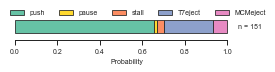

In [17]:
#plot a stacked barplot
fig,axes = plt.subplots(figsize=(4,0.5))

(df_coll_combined/df_coll_combined.sum()).T.plot(kind='barh',stacked=True,ax=axes,rot=0,edgecolor='.15',
                               color=[palettes['qualitative'][0],palettes['qualitative'][5],
                                      palettes['qualitative'][1],palettes['qualitative'][2],
                                      palettes['qualitative'][3]])
axes.set_xlabel("Probability")
#axes.set_title("Fate upon T7RNAP-OCCM collision")
axes.set_xlim([0,1.05])
axes.set_yticks([])
axes.set_yticklabels([])

labels = [int(df_coll_combined.sum()[col]) for col in df_coll_combined.columns]

#calculate y offset to label bars on top

rects = axes.patches
counter = 0
for rect, label in zip(rects, labels):
    axes.text(1.05, rect.get_y() + rect.get_height()/2, s=f'n = {label}', ha='left', va='center')
    counter+=1
axes.legend(ncol=len(df.index),bbox_to_anchor=[-0.05, 1], loc='center left',frameon=False)
#tidy up
#fig.tight_layout()
sns.despine(trim=True,left=True)

#save
plt.savefig(dir_out+'5B_OCCM_collision_fate_combined.svg',transparent=True)

### Figure 5C: RNAP pushes OCCM over long distances
*Note*: only consider DNA w/o T7T

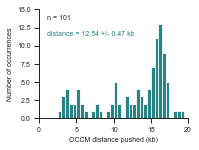

In [18]:
protein = 'OCCM'
# only consider molecules with 1 MCM foci being pushed
tag_filter = 'MCM_1_push'

_plot_df = (df[(~df['t7_terminator']) & (df['number_MCM'] == 1) & (df['tags'].apply(
    lambda tags: True if re.search(tag_filter,' '.join(tags)) else False))].filter(regex=("MCM_"),axis=1))

fig,axes = plt.subplots()

sns.distplot((_plot_df.xs('stop_site',level='properties',axis=1) -
              _plot_df.xs('start_site',level='properties',axis=1))/1000,ax=axes,
             color=sns.desaturate(palettes[protein][1],0.75) ,bins = np.linspace(0, 25, 51), kde=False, hist_kws={'alpha':1})
# mean+/- sem
mean_distance = pd.melt((_plot_df.xs('stop_site',level='properties',axis=1) - 
                         _plot_df.xs('start_site',level='properties',axis=1))/1000)['value'].mean()
sem_distance = pd.melt((_plot_df.xs('stop_site',level='properties',axis=1) - 
                         _plot_df.xs('start_site',level='properties',axis=1))/1000)['value'].sem()
axes.text(0.05, 0.8, f"distance = {round(mean_distance,2)} +/- {round(sem_distance,2)} kb",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes,color=sns.desaturate(palettes[protein][1],0.75))

axes.set_xlim(0,20)
axes.set_ylim(0,15)
axes.set_xlabel('OCCM distance pushed (kb)')
axes.set_ylabel('Number of occurrences')
#axes.legend(loc=0,frameon=False)

axes.text(0.05, 0.95, f"n = {len(_plot_df)}",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes)

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'5C_OCCM_pushed_distance.svg',transparent=True)

### Figure 5D: Transcription rate +/- OCCM

In [19]:
df_push = pd.DataFrame(columns=['initial_intensity','velocity'])

# loop through all archives with nucleotide ATPgS (just sanity check, only "ATPgS archives selected")
for archive in filter(lambda archive: archive.nucleotide == 'ATPgS',DnaMoleculeArchive.instances):

    # loop through all molecules
    for molecule in archive.molecules:
        #print('processing molecule:', molecule.uid)
        valid = True
        
        for protein, number in molecule.proteins.items():
            # make sure molecule only contains MCM & T7 
            if (number > 0 and protein not in {'T7', 'MCM'}):
                valid = False
                continue
            # more than 1 T7 (just a sanity check, shouldn't happen)
            elif number > 1 and protein != 'MCM':
                valid = False
                continue
                
        # loop through all seg_dfs with MCM in prefix
        if valid:
            for seg_df in filter(lambda seg_df: 'MCM' in seg_df.prefix, molecule.seg_dfs):
                # get the rate
                velocity = seg_df.calc_rate()[0]

                # get intensity_MCM
                intensity = 0
                # add intensities for all pushed MCMs
                for i in range(1,seg_df.pushed_proteins['MCM']+1):
                    intensity += molecule.df.iloc[:5]['MCM_'+str(i)+'_Intensity'].mean()

                _temp_df = pd.DataFrame(data=[[intensity,velocity]],
                                        columns=['initial_intensity','velocity'])
                df_push = pd.concat([df_push,_temp_df])
                
            # in case we have no MCM, take T7 velocity and add MCM intensity 0
            if len(list(filter(lambda seg_df: 'MCM' in seg_df.prefix, molecule.seg_dfs))) == 0:
                for seg_df in filter(lambda seg_df: 'T7' in seg_df.prefix, molecule.seg_dfs):
                    # get the rate
                    velocity = seg_df.calc_rate()[0]

                    # set MCM intensity to 0
                    intensity = 0
                    _temp_df = pd.DataFrame(data=[[intensity,velocity]],
                                            columns=['initial_intensity','velocity'])
                    df_push = pd.concat([df_push,_temp_df])
                
df_push = df_push.convert_dtypes()
df_push = df_push.dropna()
df_push

,initial_intensity,velocity
0,30135.4,28.510461
0,0.0,29.406737
0,14723.7,25.151466
0,14026.4,26.594233
0,0.0,29.353389
...,...,...
0,0.0,32.990352
0,0.0,27.552672
0,0.0,29.488888
0,0.0,32.125207


In [20]:
# 1 MCM has around 15000 intensity
def estimate_bleaching(intensity):
    if intensity == 0:
        return 0
    else:
        return 1

In [21]:
df_push['number_OCCM'] = df_push['initial_intensity'].apply(estimate_bleaching)

In [22]:
df_push.groupby('number_OCCM').describe()

initial_intensity                                               \
                        count          mean           std     min      25%   
number_OCCM                                                                  
0                       343.0      0.000000      0.000000     0.0      0.0   
1                       131.0  23529.954198  30052.347332  4181.9  14047.7   

                                        velocity                       \
                 50%      75%       max    count       mean       std   
number_OCCM                                                             
0                0.0      0.0       0.0    343.0  30.039321  2.951382   
1            17178.0  22272.5  268229.6    131.0  25.961447  3.437831   

                                                                    
                   min        25%        50%        75%        max  
number_OCCM                                                         
0            20.130145  28.265139  30.023484  31.769223  38.840829  
1            15.879227  24.151626  26.272169  28.446161  33.573702

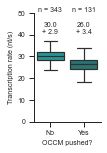

In [23]:
# Observed rates +/- OCCM
protein = 'OCCM'
fig,axes = plt.subplots(figsize=(1.2, 2))

sns.boxplot(x='number_OCCM',y='velocity',data=df_push,order=sorted(df_push['number_OCCM'].unique()),
            palette=palettes[protein][::2],fliersize=0)


#calculate number of observations
nobs = df_push['number_OCCM'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 50, nobs[tick],
    horizontalalignment='center',verticalalignment='bottom')
    
rates = []
# fit data to normal distribution and print on plot
for num_occm in sorted(df_push['number_OCCM'].unique()):
    mu, std = norm.fit(df_push[df_push['number_OCCM']==num_occm]['velocity'])
    rates.append(f'{round(mu,1)}\n+ {round(std,1)}')
    
for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 40, rates[tick],
    horizontalalignment='center',verticalalignment='bottom')
    
axes.set_xticklabels(['No','Yes'])
axes.set_ylim(0,50)
axes.set_xlabel('OCCM pushed?')
axes.set_ylabel('Transcription rate (nt/s)')

# axes.set_title('T7 RNAP can push trains of MCM DHs')

sns.despine()
# plt.tight_layout()

plt.savefig(dir_out+'5D_Transcription_rates_OCCM.svg',transparent=True)

### Figure S5C: Pausing probability during transcription
*Note*: only consider DNA w/o T7T, one MCM foci and only active pushing (pauses upon T7-MCM collision are not accounted for)

In [24]:
# 1st part, df with MCM == 1, ORC == 0, no T7T, and tags contain MCM_1_push
df_mcm = df[(~df['t7_terminator']) & (df['number_MCM'] == 1) & (df['number_ORC'] == 0) & 
            (df['tags'].apply(lambda tags: re.search('MCM_1_push', ' '.join(tags))))]['MCM_1_']
df_mcm

properties             initial_intensity lifetime number_pauses  pause_1  \
properties_details                                              duration   
ieQwV6aDnrXypabArn9wxK           30135.4    200.0           0.0      NaN   
ntzohE8juHpTgESMDENF9T           14723.7    138.0           0.0      NaN   
qRpM5HsgVnZo8thL9cgxTZ           19194.8    101.0           0.0      NaN   
rC8Rt1CpJxrM9iojXQLDpc           15743.7    120.0           0.0      NaN   
34NrmyBPRRgadXpiZqghKk           28961.4    200.0           2.0  536.940   
...                                  ...      ...           ...      ...   
4KX7a9Q4Nyx4ihgC1d8oKN           21043.1    142.0           0.0      NaN   
LBBuSkf2em9NdA9Gjooy4            20543.2    200.0           0.0      NaN   
cptp5jAwUsgUzWNvkvEjxn           18163.2    200.0           1.0  872.701   
oBnnm6kvKcQCKoumANZwWg           12581.0     95.0           0.0      NaN   
a28Kq3mPD7TUmLk9MhgbGw           10147.8    200.0           0.0      NaN   

properties                                       pause_2                  \
properties_details     position_on_dna recovery duration position_on_dna   
ieQwV6aDnrXypabArn9wxK             NaN      NaN      NaN             NaN   
ntzohE8juHpTgESMDENF9T             NaN      NaN      NaN             NaN   
qRpM5HsgVnZo8thL9cgxTZ             NaN      NaN      NaN             NaN   
rC8Rt1CpJxrM9iojXQLDpc             NaN      NaN      NaN             NaN   
34NrmyBPRRgadXpiZqghKk    11213.891722     True    41.29    15350.210002   
...                                ...      ...      ...             ...   
4KX7a9Q4Nyx4ihgC1d8oKN             NaN      NaN      NaN             NaN   
LBBuSkf2em9NdA9Gjooy4              NaN      NaN      NaN             NaN   
cptp5jAwUsgUzWNvkvEjxn     7550.073957    False      NaN             NaN   
oBnnm6kvKcQCKoumANZwWg             NaN      NaN      NaN             NaN   
a28Kq3mPD7TUmLk9MhgbGw             NaN      NaN      NaN             NaN   

properties                        start_site     stop_site  
properties_details     recovery                             
ieQwV6aDnrXypabArn9wxK      NaN  6262.440662  21892.053751  
ntzohE8juHpTgESMDENF9T      NaN  4418.542934  21345.958276  
qRpM5HsgVnZo8thL9cgxTZ      NaN  4609.956851  16271.633799  
rC8Rt1CpJxrM9iojXQLDpc      NaN  5444.109805  18432.075921  
34NrmyBPRRgadXpiZqghKk    False  4991.807509  15517.074675  
...                         ...          ...           ...  
4KX7a9Q4Nyx4ihgC1d8oKN      NaN  5449.760020  21989.909290  
LBBuSkf2em9NdA9Gjooy4       NaN  6044.317367  13106.840780  
cptp5jAwUsgUzWNvkvEjxn      NaN  3606.065020   8245.736236  
oBnnm6kvKcQCKoumANZwWg      NaN  5862.374900  21155.972571  
a28Kq3mPD7TUmLk9MhgbGw      NaN  4715.286992  20939.325214  

[101 rows x 11 columns]

In [25]:
# 2nd part, df with MCM == 0, ORC == 0, no T7T and T7 ==1
df_t7 = df[(~df['t7_terminator']) & (df['number_T7'] == 1) & (df['number_MCM'] == 0) & (df['number_ORC'] == 0)]['T7_1_']
df_t7['initial_intensity'] = 0
df_t7

properties             initial_intensity lifetime number_pauses  pause_1  \
properties_details                                              duration   
6WWUeuYF81fiqUQ1eBop1m                 0     95.0           0.0      NaN   
njwaKPQkSS9K6UFxLBKNGC                 0     83.0           1.0   183.83   
eMQQkL9xdzzMv6K6V4vAid                 0     41.0           0.0      NaN   
t2rbBPFQufXMxATUX3Gz2e                 0     18.0           0.0      NaN   
xo6cay4hgY9zi6grKr8ZAh                 0    161.0           0.0      NaN   
...                                  ...      ...           ...      ...   
xs5PaW8JvoaaDZVhAUjj3N                 0     88.0           0.0      NaN   
8qtuLurWozidURyGzDYLjb                 0     98.0           0.0      NaN   
fTpnRSXWayTMDhKXwcQWxr                 0     92.0           0.0      NaN   
wt523HhdCSYkWWEW54StJ7                 0     97.0           0.0      NaN   
8oqeq11BxmZhCihiU58fEK                 0    107.0           0.0      NaN   

properties                                       pause_2                  \
properties_details     position_on_dna recovery duration position_on_dna   
6WWUeuYF81fiqUQ1eBop1m             NaN      NaN      NaN             NaN   
njwaKPQkSS9K6UFxLBKNGC    11443.783747    False      NaN             NaN   
eMQQkL9xdzzMv6K6V4vAid             NaN      NaN      NaN             NaN   
t2rbBPFQufXMxATUX3Gz2e             NaN      NaN      NaN             NaN   
xo6cay4hgY9zi6grKr8ZAh             NaN      NaN      NaN             NaN   
...                                ...      ...      ...             ...   
xs5PaW8JvoaaDZVhAUjj3N             NaN      NaN      NaN             NaN   
8qtuLurWozidURyGzDYLjb             NaN      NaN      NaN             NaN   
fTpnRSXWayTMDhKXwcQWxr             NaN      NaN      NaN             NaN   
wt523HhdCSYkWWEW54StJ7             NaN      NaN      NaN             NaN   
8oqeq11BxmZhCihiU58fEK             NaN      NaN      NaN             NaN   

properties                        start_site     stop_site  
properties_details     recovery                             
6WWUeuYF81fiqUQ1eBop1m      NaN  3277.121282  16553.977834  
njwaKPQkSS9K6UFxLBKNGC      NaN  3318.315574  12381.984088  
eMQQkL9xdzzMv6K6V4vAid      NaN  3341.005331   8267.952301  
t2rbBPFQufXMxATUX3Gz2e      NaN  3802.451114   5879.341241  
xo6cay4hgY9zi6grKr8ZAh      NaN  3234.255702  21296.862623  
...                         ...          ...           ...  
xs5PaW8JvoaaDZVhAUjj3N      NaN  2373.568128  21065.427738  
8qtuLurWozidURyGzDYLjb      NaN  2046.073360  19126.680702  
fTpnRSXWayTMDhKXwcQWxr      NaN  3546.985807  19817.947355  
wt523HhdCSYkWWEW54StJ7      NaN  3384.991767  22329.918371  
8oqeq11BxmZhCihiU58fEK      NaN  2879.389222  20709.941606  

[336 rows x 11 columns]

In [26]:
df_pause = pd.concat([df_mcm, df_t7])
df_pause

properties             initial_intensity lifetime number_pauses  pause_1  \
properties_details                                              duration   
ieQwV6aDnrXypabArn9wxK           30135.4    200.0           0.0      NaN   
ntzohE8juHpTgESMDENF9T           14723.7    138.0           0.0      NaN   
qRpM5HsgVnZo8thL9cgxTZ           19194.8    101.0           0.0      NaN   
rC8Rt1CpJxrM9iojXQLDpc           15743.7    120.0           0.0      NaN   
34NrmyBPRRgadXpiZqghKk           28961.4    200.0           2.0   536.94   
...                                  ...      ...           ...      ...   
xs5PaW8JvoaaDZVhAUjj3N               0.0     88.0           0.0      NaN   
8qtuLurWozidURyGzDYLjb               0.0     98.0           0.0      NaN   
fTpnRSXWayTMDhKXwcQWxr               0.0     92.0           0.0      NaN   
wt523HhdCSYkWWEW54StJ7               0.0     97.0           0.0      NaN   
8oqeq11BxmZhCihiU58fEK               0.0    107.0           0.0      NaN   

properties                                       pause_2                  \
properties_details     position_on_dna recovery duration position_on_dna   
ieQwV6aDnrXypabArn9wxK             NaN      NaN      NaN             NaN   
ntzohE8juHpTgESMDENF9T             NaN      NaN      NaN             NaN   
qRpM5HsgVnZo8thL9cgxTZ             NaN      NaN      NaN             NaN   
rC8Rt1CpJxrM9iojXQLDpc             NaN      NaN      NaN             NaN   
34NrmyBPRRgadXpiZqghKk    11213.891722     True    41.29    15350.210002   
...                                ...      ...      ...             ...   
xs5PaW8JvoaaDZVhAUjj3N             NaN      NaN      NaN             NaN   
8qtuLurWozidURyGzDYLjb             NaN      NaN      NaN             NaN   
fTpnRSXWayTMDhKXwcQWxr             NaN      NaN      NaN             NaN   
wt523HhdCSYkWWEW54StJ7             NaN      NaN      NaN             NaN   
8oqeq11BxmZhCihiU58fEK             NaN      NaN      NaN             NaN   

properties                        start_site     stop_site  
properties_details     recovery                             
ieQwV6aDnrXypabArn9wxK      NaN  6262.440662  21892.053751  
ntzohE8juHpTgESMDENF9T      NaN  4418.542934  21345.958276  
qRpM5HsgVnZo8thL9cgxTZ      NaN  4609.956851  16271.633799  
rC8Rt1CpJxrM9iojXQLDpc      NaN  5444.109805  18432.075921  
34NrmyBPRRgadXpiZqghKk    False  4991.807509  15517.074675  
...                         ...          ...           ...  
xs5PaW8JvoaaDZVhAUjj3N      NaN  2373.568128  21065.427738  
8qtuLurWozidURyGzDYLjb      NaN  2046.073360  19126.680702  
fTpnRSXWayTMDhKXwcQWxr      NaN  3546.985807  19817.947355  
wt523HhdCSYkWWEW54StJ7      NaN  3384.991767  22329.918371  
8oqeq11BxmZhCihiU58fEK      NaN  2879.389222  20709.941606  

[437 rows x 11 columns]

In [27]:
df_pause['number_OCCM'] = df_pause['initial_intensity'].apply(estimate_bleaching)
df_pause

properties             initial_intensity lifetime number_pauses  pause_1  \
properties_details                                              duration   
ieQwV6aDnrXypabArn9wxK           30135.4    200.0           0.0      NaN   
ntzohE8juHpTgESMDENF9T           14723.7    138.0           0.0      NaN   
qRpM5HsgVnZo8thL9cgxTZ           19194.8    101.0           0.0      NaN   
rC8Rt1CpJxrM9iojXQLDpc           15743.7    120.0           0.0      NaN   
34NrmyBPRRgadXpiZqghKk           28961.4    200.0           2.0   536.94   
...                                  ...      ...           ...      ...   
xs5PaW8JvoaaDZVhAUjj3N               0.0     88.0           0.0      NaN   
8qtuLurWozidURyGzDYLjb               0.0     98.0           0.0      NaN   
fTpnRSXWayTMDhKXwcQWxr               0.0     92.0           0.0      NaN   
wt523HhdCSYkWWEW54StJ7               0.0     97.0           0.0      NaN   
8oqeq11BxmZhCihiU58fEK               0.0    107.0           0.0      NaN   

properties                                       pause_2                  \
properties_details     position_on_dna recovery duration position_on_dna   
ieQwV6aDnrXypabArn9wxK             NaN      NaN      NaN             NaN   
ntzohE8juHpTgESMDENF9T             NaN      NaN      NaN             NaN   
qRpM5HsgVnZo8thL9cgxTZ             NaN      NaN      NaN             NaN   
rC8Rt1CpJxrM9iojXQLDpc             NaN      NaN      NaN             NaN   
34NrmyBPRRgadXpiZqghKk    11213.891722     True    41.29    15350.210002   
...                                ...      ...      ...             ...   
xs5PaW8JvoaaDZVhAUjj3N             NaN      NaN      NaN             NaN   
8qtuLurWozidURyGzDYLjb             NaN      NaN      NaN             NaN   
fTpnRSXWayTMDhKXwcQWxr             NaN      NaN      NaN             NaN   
wt523HhdCSYkWWEW54StJ7             NaN      NaN      NaN             NaN   
8oqeq11BxmZhCihiU58fEK             NaN      NaN      NaN             NaN   

properties                        start_site     stop_site number_OCCM  
properties_details     recovery                                         
ieQwV6aDnrXypabArn9wxK      NaN  6262.440662  21892.053751           1  
ntzohE8juHpTgESMDENF9T      NaN  4418.542934  21345.958276           1  
qRpM5HsgVnZo8thL9cgxTZ      NaN  4609.956851  16271.633799           1  
rC8Rt1CpJxrM9iojXQLDpc      NaN  5444.109805  18432.075921           1  
34NrmyBPRRgadXpiZqghKk    False  4991.807509  15517.074675           1  
...                         ...          ...           ...         ...  
xs5PaW8JvoaaDZVhAUjj3N      NaN  2373.568128  21065.427738           0  
8qtuLurWozidURyGzDYLjb      NaN  2046.073360  19126.680702           0  
fTpnRSXWayTMDhKXwcQWxr      NaN  3546.985807  19817.947355           0  
wt523HhdCSYkWWEW54StJ7      NaN  3384.991767  22329.918371           0  
8oqeq11BxmZhCihiU58fEK      NaN  2879.389222  20709.941606           0  

[437 rows x 12 columns]

In [28]:
df_pause.groupby('number_OCCM').describe()['number_pauses']

properties_details                                                    
                    count      mean       std  min  25%  50%  75%  max
number_OCCM                                                           
0                   336.0  0.142857  0.375133  0.0  0.0  0.0  0.0  2.0
1                   101.0  0.405941  0.532508  0.0  0.0  0.0  1.0  2.0

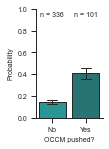

In [29]:
protein = 'OCCM'

fig,axes = plt.subplots(figsize=(1.2, 2))

sns.barplot(x='number_OCCM',y='number_pauses',data=df_pause,order=[0,1],
            palette=palettes[protein][::2],lw=1, edgecolor='.15', capsize=.3,errwidth=1, ax=axes, 
            n_boot=10000, seed=42, ci=68, errcolor='.15')
axes.set_xlabel('OCCM pushed?')
axes.set_ylabel('Probability')
axes.set_xticklabels(['No','Yes'])
#axes.set_title(f'T7 pause frequency')
axes.set_ylim([0,1])
#calculate number of observations
nobs = df_pause['number_OCCM'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot
pos = range(len(nobs))
for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 0.95, nobs[tick],
    horizontalalignment='center',verticalalignment='center')

sns.despine()
#plt.tight_layout()

#save
plt.savefig(dir_out+'S5C_pause_probability_OCCM.svg',transparent=True)

### Figures S5D: Pause recovery
*Note*: only consider DNA w/o T7T, one MCM foci and only active pushing (pauses upon T7-MCM collision are not accounted for)

In [30]:
_plot_df = pd.DataFrame(columns=['duration','recovery','number_OCCM'])
for index in df_pause.index:
    # check how many pauses we got
    for i in range(1,int(df_pause.loc[index,('number_pauses','')]+1)):
        
        _temp_df = pd.DataFrame(data=[[df_pause.loc[index,('pause_'+str(i),'duration')],
                                      df_pause.loc[index,('pause_'+str(i),'recovery')],
                                      df_pause.loc[index,('number_OCCM','')]]],
                                      columns=['duration','recovery','number_OCCM'])
        _plot_df = pd.concat([_plot_df,_temp_df])
    
_plot_df = _plot_df.convert_dtypes()
_plot_df.head()

,duration,recovery,number_OCCM
0,536.940,True,1
0,41.290,False,1
0,163.080,True,1
0,57.390,True,1
0,432.691,False,1


In [31]:
_plot_df['recovery_bin'] = _plot_df['recovery'].apply(lambda recovery: 1 if recovery else 0)
_plot_df.head()

,duration,recovery,number_OCCM,recovery_bin
0,536.940,True,1,1
0,41.290,False,1,0
0,163.080,True,1,1
0,57.390,True,1,1
0,432.691,False,1,0


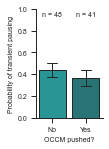

In [32]:
protein = 'OCCM'
fig,axes = plt.subplots(figsize=(1.2, 2))

sns.barplot(x='number_OCCM',y='recovery_bin', data=_plot_df,
            order=sorted(df_pause['number_OCCM'].unique()),
            palette=palettes[protein][::2],lw=1, edgecolor='.15', capsize=.3,errwidth=1, ax=axes, 
            n_boot=10000, seed=42, ci=68, errcolor='.15')

axes.set_ylim(0,1)
axes.set_xlabel('OCCM pushed?')
axes.set_ylabel('Probability of transient pausing')
#axes.set_title('Recovery from transcription pauses')
axes.set_xticklabels(['No','Yes'])

#calculate number of observations
nobs = _plot_df['number_OCCM'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot
pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    transform=axes.transAxes, axes.text(pos[tick], 0.95, nobs[tick],
    horizontalalignment='center',verticalalignment='center')

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S5D_Pause_recovery_OCCM.svg',transparent=True)


### Figure S5E: Pause durations (only transient pauses)
*Note*: only consider DNA w/o T7T, one MCM foci and only active pushing (pauses upon T7-MCM collision are not accounted for)

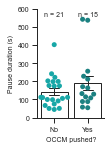

In [33]:
protein = 'OCCM'
fig,axes = plt.subplots(figsize=(1.2, 2))

sns.swarmplot(x='number_OCCM',y='duration', data=_plot_df[_plot_df['recovery']],
              order=sorted(df_pause['number_OCCM'].unique()), palette=palettes[protein][::2], ax=axes)
sns.barplot(x='number_OCCM',y='duration', data=_plot_df[_plot_df['recovery']],
              order=sorted(df_pause['number_OCCM'].unique()), facecolor=(1, 1, 1, 0),
            palette=palettes[protein][::2],lw=1, edgecolor='.15', capsize=.3,errwidth=1, ax=axes, 
            n_boot=10000, seed=42, ci=68, errcolor='.15')

axes.set_ylim(0,600)
axes.set_xlabel('OCCM pushed?')
axes.set_ylabel('Pause duration (s)')
axes.set_xticklabels(['No','Yes'])
#axes.set_title('Recovery from transcription pauses')

#calculate number of observations
nobs = _plot_df[_plot_df['recovery']]['number_OCCM'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot
pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    transform=axes.transAxes, axes.text(pos[tick], 570, nobs[tick],
    horizontalalignment='center',verticalalignment='center')

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S5E_Pause_duration_OCCM.svg',transparent=True)


### Figure S5F: Observed ORC and MCM loss upon collision in 3-color experiment

In [34]:
df_occm_loss = df_coll3c.copy()
df_occm_loss

,outcome
push,19
stall,1
T7eject,7
MCMeject,3
ORCeject,1


In [35]:
df_occm_loss.loc['intact','outcome'] = (
    df_occm_loss.loc['push','outcome'] + df_occm_loss.loc['stall','outcome'] + df_occm_loss.loc['T7eject','outcome'])
df_occm_loss.loc['disassembled'] = (df_occm_loss.loc['MCMeject','outcome'] + df_occm_loss.loc['ORCeject','outcome'])
df_occm_loss.drop(['push','stall','T7eject','MCMeject','ORCeject'], axis=0, inplace=True)
df_occm_loss

,outcome
intact,27.0
disassembled,4.0


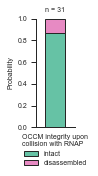

In [36]:
#plot a stacked barplot
fig,axes = plt.subplots(figsize=(0.7, 2))

(df_occm_loss/df_occm_loss.sum()).T.plot(kind='bar',stacked=True,ax=axes,rot=0,lw=1,edgecolor='.15',
                               color=[palettes['qualitative'][0],palettes['qualitative'][3]])

axes.set_ylabel("Probability")
#axes.set_title("Fate upon T7RNAP-OCCM collision")
axes.set_ylim([0,1])
axes.set_xticks([])

labels = [int(df_occm_loss.sum()[col]) for col in df_occm_loss.columns]

#calculate y offset to label bars on top

rects = axes.patches
counter = 0
for rect, label in zip(rects, labels):
    axes.text(rect.get_x() + rect.get_width()/2, 1.05, s=f'n = {label}', ha='center', va='bottom')
    counter+=1
axes.legend(title='OCCM integrity upon\ncollision with RNAP',bbox_to_anchor=[0.5, 0],
            loc='upper center',frameon=False)
#tidy up
#fig.tight_layout()
sns.despine()

#save
plt.savefig(dir_out+'S5F_RNAP-OCCM_collision_OCCM_survival.svg',transparent=True)